In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, r2_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df_first240 = pd.read_csv("../data/first_240.csv")
df_from_240_to_360 = pd.read_csv("../data/from_240_to_360.csv")
df_from_360_to_480 = pd.read_csv("../data/from_360_480.csv")

In [3]:
df_moves = pd.concat([df_first240, df_from_240_to_360, df_from_360_to_480])
GAME_COUNT = 480

In [4]:
df_games = pd.read_csv("../data/clear_data.csv")
df_games = df_games.head(GAME_COUNT)
df_games['game_id'].value_counts()

game_id
0      1
1      1
328    1
327    1
326    1
      ..
155    1
154    1
153    1
152    1
479    1
Name: count, Length: 480, dtype: int64

Для начала попробуем угадывать рейтинг только белого игрока. С черным должно быть то же самое

In [5]:
def percent_best_move(game_id, ost=0):
    # ost = 0 если смотрим ходы белых, иначе ost = 1
    move_in_game = df_moves[(df_moves['game_id'] == game_id) & (df_moves['move_number'] % 2 == ost)]
    matches = move_in_game[
        (move_in_game['move'] == move_in_game['best_line_1_move']) |
        (move_in_game['move'] == move_in_game['best_line_2_move']) |
        (move_in_game['move'] == move_in_game['best_line_3_move'])
        ]
    return matches.shape[0] / move_in_game.shape[0]

In [6]:
from rating_to_category import rating_to_number_easy

df_games['white_percent_best_move'] = df_games['game_id'].apply(percent_best_move)
df_games['white_rating_num'] = df_games['white_elo'].apply(rating_to_number_easy)
df_games

,Events,results,white_elo,black_elo,white_rating_diff,black_rating_diff,ecos,openings,time_control,termination,game_id,white_percent_best_move,white_rating_num
0,Rated Classical game,1-0,1639,1403,5,-8,C00,French Defense: Normal Variation,600+8,Normal,0,0.538462,1
1,Rated Classical game,1-0,1654,1919,19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1,0.722222,1
2,Rated Classical game,1-0,1643,1747,13,-94,C50,Four Knights Game: Italian Variation,420+17,Normal,2,0.909091,1
3,Rated Bullet game,0-1,1824,1973,-6,8,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal,3,0.723404,2
4,Rated Bullet game,0-1,1765,1815,-9,9,C00,French Defense: La Bourdonnais Variation,60+1,Normal,4,0.478261,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Rated Bullet game,1-0,1505,1404,8,-13,C34,"King's Gambit Accepted, Schallopp Defense",120+0,Time forfeit,475,0.542857,1
476,Rated Classical game,0-1,1500,1540,-157,7,B23,Sicilian Defense: Closed Variation,1560+30,Normal,476,0.440000,1
477,Rated Bullet game,1-0,1858,1851,13,-13,D31,Queen's Gambit Declined: Queen's Knight Variation,60+0,Normal,477,0.750000,2
478,Rated Bullet game,1-0,1395,1558,34,-17,C20,King's Pawn Game: King's Head Opening #2,60+0,Time forfeit,478,0.400000,0


In [7]:
df_games['white_rating_num'].value_counts()

white_rating_num
1    252
2    158
0     70
Name: count, dtype: int64

In [8]:
df_train = df_games[['Events', 'results', 'termination', 'white_percent_best_move']]
df_train = pd.get_dummies(df_train, columns=['termination', 'Events', 'results'])
df_train

,white_percent_best_move,termination_Normal,termination_Time forfeit,Events_Rated Blitz game,Events_Rated Bullet game,Events_Rated Classical game,results_0-1,results_1-0,results_1/2-1/2
0,0.538462,True,False,False,False,True,False,True,False
1,0.722222,True,False,False,False,True,False,True,False
2,0.909091,True,False,False,False,True,False,True,False
3,0.723404,True,False,False,True,False,True,False,False
4,0.478261,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
475,0.542857,False,True,False,True,False,False,True,False
476,0.440000,True,False,False,False,True,True,False,False
477,0.750000,True,False,False,True,False,False,True,False
478,0.400000,False,True,False,True,False,False,True,False


В качестве признаков возьмем процент ходов, которые мы считаем наилучшими

In [9]:
x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(
    df_train, df_games['white_rating_num'],
    train_size=0.8,
    random_state=42)
x_train_white.shape, x_test_white.shape, y_train_white.shape, y_test_white.shape

((384, 9), (96, 9), (384,), (96,))

In [10]:
from catboost import CatBoostClassifier


def get_fit_predict_res(x_train, x_test, y_train, y_test):
    models = {
        "LogisticRegression": LogisticRegression(),
        "RandomForestClassifier": RandomForestClassifier(),
        "Catboost": CatBoostClassifier()
    }
    results = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        results.append({
            "model": name,
            "f1_score test": f1_score(y_true=y_test, y_pred=y_pred_test, average='micro'),
            "r2_score test": r2_score(y_true=y_test, y_pred=y_pred_test),
            "balanced_accuracy test": balanced_accuracy_score(y_true=y_test, y_pred=y_pred_test),
            "f1_score train": f1_score(y_true=y_train, y_pred=y_pred_train, average='micro'),
            "r2_score train": r2_score(y_true=y_train, y_pred=y_pred_train),
            "balanced_accuracy train": balanced_accuracy_score(y_true=y_train, y_pred=y_pred_train),
        })
    return pd.DataFrame(results)


get_fit_predict_res(x_train_white, x_test_white, y_train_white, y_test_white)

Learning rate set to 0.075357
0:	learn: 1.0700893	total: 54.4ms	remaining: 54.3s
1:	learn: 1.0475366	total: 71.6ms	remaining: 35.7s
2:	learn: 1.0229904	total: 74.5ms	remaining: 24.8s
3:	learn: 1.0082605	total: 75ms	remaining: 18.7s
4:	learn: 0.9928703	total: 76.3ms	remaining: 15.2s
5:	learn: 0.9778041	total: 78.4ms	remaining: 13s
6:	learn: 0.9597665	total: 83.2ms	remaining: 11.8s
7:	learn: 0.9435121	total: 135ms	remaining: 16.7s
8:	learn: 0.9293849	total: 157ms	remaining: 17.2s
9:	learn: 0.9182358	total: 194ms	remaining: 19.2s
10:	learn: 0.9064412	total: 197ms	remaining: 17.7s
11:	learn: 0.8934779	total: 200ms	remaining: 16.5s
12:	learn: 0.8840752	total: 207ms	remaining: 15.7s
13:	learn: 0.8729571	total: 210ms	remaining: 14.8s
14:	learn: 0.8653572	total: 212ms	remaining: 13.9s
15:	learn: 0.8583417	total: 213ms	remaining: 13.1s
16:	learn: 0.8515658	total: 215ms	remaining: 12.4s
17:	learn: 0.8440079	total: 217ms	remaining: 11.9s
18:	learn: 0.8364887	total: 219ms	remaining: 11.3s
19:	lear

,model,f1_score test,r2_score test,balanced_accuracy test,f1_score train,r2_score train,balanced_accuracy train
0,LogisticRegression,0.572917,0.106410,0.453488,0.648438,0.11440,0.467645
1,RandomForestClassifier,0.572917,-0.137296,0.541002,0.942708,0.82780,0.911144
2,Catboost,0.552083,0.004866,0.485408,0.911458,0.69865,0.859435


Результаты не впечатляют, давайте попробуем убрать все игры в пулю, т.к. в предположении люди почти не думают, прежде чем там сходить

In [11]:
df_games_without_bullet = df_games[df_games['Events'] != 'Rated Bullet game']
df_games_without_bullet['Events'].value_counts()

Events
Rated Classical game    129
Rated Blitz game        108
Name: count, dtype: int64

In [12]:
df_train = df_games_without_bullet[['Events', 'results', 'termination', 'white_percent_best_move']]
df_train = pd.get_dummies(df_train, columns=['termination', 'Events', 'results'])
x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(
    df_train, df_games_without_bullet['white_rating_num'],
    train_size=0.8,
    random_state=42)
x_train_white.shape, x_test_white.shape, y_train_white.shape, y_test_white.shape

((189, 8), (48, 8), (189,), (48,))

In [13]:
get_fit_predict_res(x_train_white, x_test_white, y_train_white, y_test_white)

Learning rate set to 0.072681
0:	learn: 1.0728622	total: 636us	remaining: 636ms
1:	learn: 1.0508926	total: 2.64ms	remaining: 1.32s
2:	learn: 1.0307219	total: 3.24ms	remaining: 1.08s
3:	learn: 1.0128898	total: 4.07ms	remaining: 1.01s
4:	learn: 0.9968712	total: 5.4ms	remaining: 1.07s
5:	learn: 0.9820160	total: 6.85ms	remaining: 1.13s
6:	learn: 0.9681834	total: 8.41ms	remaining: 1.19s
7:	learn: 0.9530941	total: 9.96ms	remaining: 1.24s
8:	learn: 0.9435799	total: 11ms	remaining: 1.21s
9:	learn: 0.9314209	total: 13.6ms	remaining: 1.34s
10:	learn: 0.9233355	total: 14.1ms	remaining: 1.27s
11:	learn: 0.9122805	total: 16ms	remaining: 1.32s
12:	learn: 0.9025729	total: 17.1ms	remaining: 1.29s
13:	learn: 0.8946491	total: 18.6ms	remaining: 1.31s
14:	learn: 0.8886344	total: 19.9ms	remaining: 1.3s
15:	learn: 0.8803685	total: 21.1ms	remaining: 1.3s
16:	learn: 0.8762688	total: 21.3ms	remaining: 1.23s
17:	learn: 0.8707520	total: 22.8ms	remaining: 1.24s
18:	learn: 0.8634184	total: 24.2ms	remaining: 1.25s


,model,f1_score test,r2_score test,balanced_accuracy test,f1_score train,r2_score train,balanced_accuracy train
0,LogisticRegression,0.666667,-0.282137,0.323232,0.613757,0.006409,0.363824
1,RandomForestClassifier,0.479167,-1.484140,0.278943,0.931217,0.823059,0.889540
2,Catboost,0.604167,-0.762938,0.355089,0.931217,0.823059,0.894578


Возможно дело в том, что только 1 признак. Давайте добавим в наша датафрейм ещё признаков, посмотрим что из этого выйдет

In [14]:
def min_max_delta_centipawns(game_id, ost=0, want=0):
    # ost = 0, если смотрим на ходы белых
    # want = 0, если интересуемся минимумом, want = 1, если нужен максимум и want = 2, если медиана
    last = 0
    _id = 0
    min_max_median_delta = (1000, -1000, 0)
    for centipawns in df_moves[df_moves['game_id'] == game_id].sort_values(by='move_number')['centipawns']:
        if _id % 2 == ost and not np.isnan(centipawns):
            min_max_median_delta = (
                min(min_max_median_delta[0], centipawns - last), max(min_max_median_delta[1], centipawns - last),
                min_max_median_delta[2] + centipawns)
        last = centipawns
        _id += 1
    min_max_median_delta = (
        min_max_median_delta[0] / 1000, min_max_median_delta[1] / 1000, (min_max_median_delta[2] / _id) / 1000)
    if want == 0:
        return min_max_median_delta[0]
    elif want == 1:
        return min_max_median_delta[1]
    return min_max_median_delta[2]


def min_centipawns_white(game_id):
    return min_max_delta_centipawns(game_id, ost=0, want=0)


def max_centipawns_white(game_id):
    return min_max_delta_centipawns(game_id, ost=0, want=1)


def median_centipawns_white(game_id):
    return min_max_delta_centipawns(game_id, ost=0, want=2)


def min_centipawns_black(game_id):
    return min_max_delta_centipawns(game_id, ost=1, want=0)


def max_centipawns_black(game_id):
    return min_max_delta_centipawns(game_id, ost=1, want=1)


def median_centipawns_black(game_id):
    return min_max_delta_centipawns(game_id, ost=1, want=2)


df_games['min_delta_centipawns_white'] = df_games['game_id'].apply(min_centipawns_white)
df_games['max_delta_centipawns_white'] = df_games['game_id'].apply(max_centipawns_white)
df_games['median_centipawns_white'] = df_games['game_id'].apply(median_centipawns_white)
df_games.sort_values(by='white_elo')

,Events,results,white_elo,black_elo,white_rating_diff,black_rating_diff,ecos,openings,time_control,termination,game_id,white_percent_best_move,white_rating_num,min_delta_centipawns_white,max_delta_centipawns_white,median_centipawns_white
348,Rated Classical game,1-0,1035,1608,35,-21,A00,Van't Kruijs Opening,480+16,Time forfeit,348,0.166667,0,-0.636,0.016,-0.205364
282,Rated Bullet game,0-1,1095,1516,-3,2,A41,Queen's Pawn,0+1,Time forfeit,282,0.428571,0,-0.381,0.036,0.055571
283,Rated Bullet game,0-1,1095,1516,-3,2,B00,Owen Defense: Smith Gambit,0+1,Time forfeit,283,0.285714,0,-0.134,0.036,0.041786
281,Rated Bullet game,0-1,1098,1514,-3,2,D02,Queen's Pawn Game: Zukertort Variation,0+1,Time forfeit,281,0.500000,0,-0.053,0.036,0.032000
254,Rated Bullet game,0-1,1100,1208,-109,38,C46,Three Knights Opening,60+0,Time forfeit,254,0.666667,0,-0.085,0.033,0.076333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Rated Bullet game,1-0,1965,1989,28,-16,A34,"English Opening: Symmetrical Variation, Three ...",120+0,Time forfeit,377,0.680000,2,-0.421,0.028,0.076980
27,Rated Bullet game,1-0,1981,1601,2,-3,A15,"English Opening: Anglo-Indian Defense, King's ...",60+1,Time forfeit,27,0.775510,2,-0.118,0.023,0.060969
335,Rated Bullet game,0-1,1993,1976,-34,17,A10,"English Opening: Anglo-Scandinavian Defense, S...",120+0,Time forfeit,335,0.603175,2,-0.602,0.941,0.337881
349,Rated Bullet game,1-0,1993,1959,14,-28,E07,Catalan Opening: Closed Variation,120+0,Normal,349,0.675676,2,-0.664,0.071,-0.003370


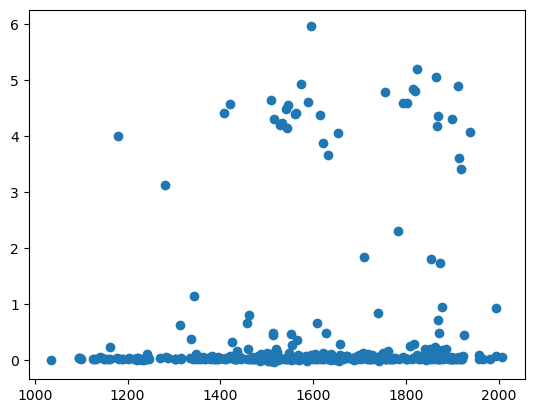

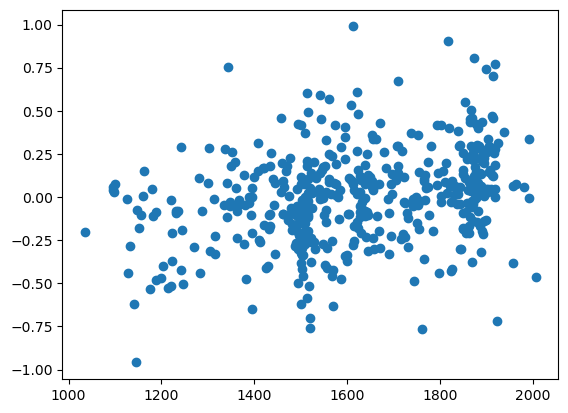

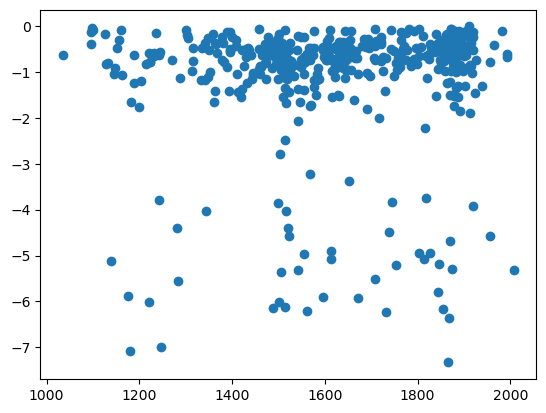

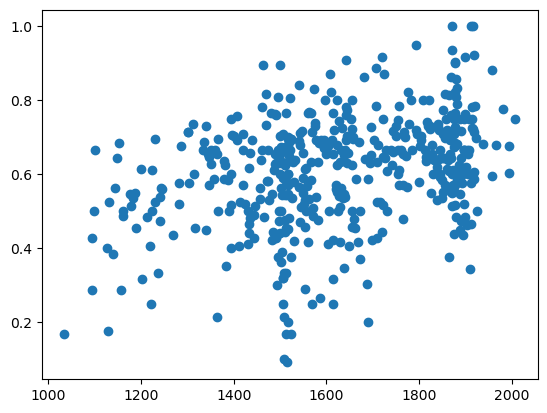

In [15]:
plt.scatter(df_games['white_elo'], df_games['max_delta_centipawns_white'])
plt.show()
plt.scatter(df_games['white_elo'], df_games['median_centipawns_white'])
plt.show()
plt.scatter(df_games['white_elo'], df_games['min_delta_centipawns_white'])
plt.show()
plt.scatter(df_games['white_elo'], df_games['white_percent_best_move'])
plt.show()

Попробуем обучиться на этих признаках

In [16]:
df_games

,Events,results,white_elo,black_elo,white_rating_diff,black_rating_diff,ecos,openings,time_control,termination,game_id,white_percent_best_move,white_rating_num,min_delta_centipawns_white,max_delta_centipawns_white,median_centipawns_white
0,Rated Classical game,1-0,1639,1403,5,-8,C00,French Defense: Normal Variation,600+8,Normal,0,0.538462,1,-0.921,0.033,-0.085560
1,Rated Classical game,1-0,1654,1919,19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1,0.722222,1,-0.474,0.036,0.090143
2,Rated Classical game,1-0,1643,1747,13,-94,C50,Four Knights Game: Italian Variation,420+17,Normal,2,0.909091,1,-0.108,0.033,0.248286
3,Rated Bullet game,0-1,1824,1973,-6,8,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal,3,0.723404,2,-0.599,0.096,-0.430777
4,Rated Bullet game,0-1,1765,1815,-9,9,C00,French Defense: La Bourdonnais Variation,60+1,Normal,4,0.478261,2,-0.619,0.033,-0.361174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Rated Bullet game,1-0,1505,1404,8,-13,C34,"King's Gambit Accepted, Schallopp Defense",120+0,Time forfeit,475,0.542857,1,-0.966,0.057,-0.104043
476,Rated Classical game,0-1,1500,1540,-157,7,B23,Sicilian Defense: Closed Variation,1560+30,Normal,476,0.440000,1,-0.627,0.033,-0.212180
477,Rated Bullet game,1-0,1858,1851,13,-13,D31,Queen's Gambit Declined: Queen's Knight Variation,60+0,Normal,477,0.750000,2,-0.414,0.075,0.218764
478,Rated Bullet game,1-0,1395,1558,34,-17,C20,King's Pawn Game: King's Head Opening #2,60+0,Time forfeit,478,0.400000,0,-0.570,0.033,-0.646692


In [17]:
df_train = df_games[['white_percent_best_move', 'min_delta_centipawns_white', 'max_delta_centipawns_white', 'median_centipawns_white']]
x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(
    df_train, df_games['white_rating_num'],
    train_size=0.8,
    random_state=42)
x_train_white.shape, x_test_white.shape, y_train_white.shape, y_test_white.shape

((384, 4), (96, 4), (384,), (96,))

In [18]:
get_fit_predict_res(x_train_white, x_test_white, y_train_white, y_test_white)

Learning rate set to 0.075357
0:	learn: 1.0776376	total: 1.84ms	remaining: 1.84s
1:	learn: 1.0581220	total: 3.17ms	remaining: 1.58s
2:	learn: 1.0393467	total: 4.44ms	remaining: 1.47s
3:	learn: 1.0241225	total: 5.57ms	remaining: 1.39s
4:	learn: 1.0067153	total: 6.75ms	remaining: 1.34s
5:	learn: 0.9904570	total: 8.05ms	remaining: 1.33s
6:	learn: 0.9756204	total: 9.16ms	remaining: 1.3s
7:	learn: 0.9626726	total: 10.5ms	remaining: 1.3s
8:	learn: 0.9517609	total: 11.8ms	remaining: 1.29s
9:	learn: 0.9400305	total: 13ms	remaining: 1.29s
10:	learn: 0.9287087	total: 14.3ms	remaining: 1.29s
11:	learn: 0.9186903	total: 15.7ms	remaining: 1.3s
12:	learn: 0.9107092	total: 17ms	remaining: 1.29s
13:	learn: 0.9042007	total: 18.4ms	remaining: 1.29s
14:	learn: 0.8959418	total: 19.7ms	remaining: 1.29s
15:	learn: 0.8864677	total: 20.8ms	remaining: 1.28s
16:	learn: 0.8787619	total: 22.1ms	remaining: 1.28s
17:	learn: 0.8707367	total: 23.4ms	remaining: 1.27s
18:	learn: 0.8664393	total: 24.7ms	remaining: 1.27s

,model,f1_score test,r2_score test,balanced_accuracy test,f1_score train,r2_score train,balanced_accuracy train
0,LogisticRegression,0.510417,0.045483,0.391904,0.557292,-0.0824,0.367467
1,RandomForestClassifier,0.489583,-0.116988,0.400111,1.000000,1.0000,1.000000
2,Catboost,0.500000,-0.218532,0.422734,1.000000,1.0000,1.000000
